# DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

- Creating new features
- Applying more overfitting-prevention strategies like subsampling
- More iterations
- Trying a different loss function
- Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!


In [135]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as matplot
import seaborn as sns
import nbconvert

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [136]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


             idno      year     tvtot   ppltrst   pplfair    pplhlp     happy  \
idno     1.000000  0.002102  0.003963 -0.007523  0.007397  0.004484 -0.003065   
year     0.002102  1.000000 -0.031596 -0.001600  0.004283 -0.032901 -0.013378   
tvtot    0.003963 -0.031596  1.000000 -0.142422 -0.119277 -0.069080 -0.118598   
ppltrst -0.007523 -0.001600 -0.142422  1.000000  0.597506  0.459250  0.231533   
pplfair  0.007397  0.004283 -0.119277  0.597506  1.000000  0.480931  0.247755   
pplhlp   0.004484 -0.032901 -0.069080  0.459250  0.480931  1.000000  0.215323   
happy   -0.003065 -0.013378 -0.118598  0.231533  0.247755  0.215323  1.000000   
sclmeet -0.021376 -0.028502 -0.078864  0.122555  0.096501  0.080489  0.182944   
sclact   0.004323  0.012150 -0.092375  0.137491  0.128808  0.092673  0.192030   
gndr     0.010851  0.001355  0.017922 -0.029921  0.022251  0.042046 -0.022413   
agea     0.030051 -0.003520  0.257674 -0.029412  0.014724  0.040351 -0.042970   
partner -0.014931  0.018689 

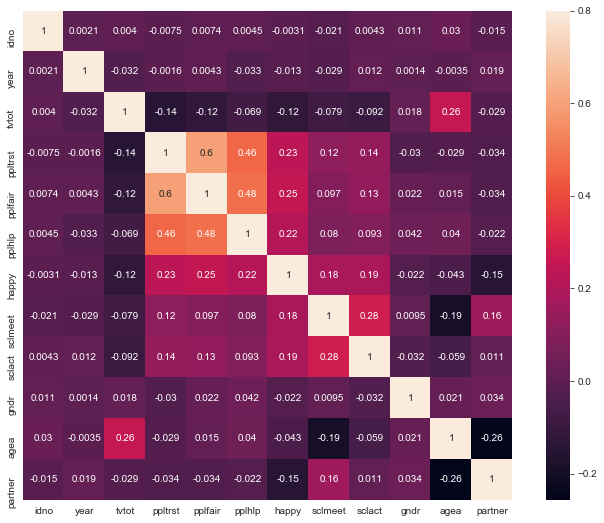

In [137]:
sns.set_style('white')

# Let's see how our current features correlate with one another.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using Seaborn.
sns.heatmap(corrmat, annot=True, vmax=.8, square=True)
plt.show()

In [138]:
# Create new feature using people being fair, trust worthy and helping nature

means = df[['ppltrst', 'pplfair', 'pplhlp']].mean(axis=0)
stds = df[['ppltrst', 'pplfair', 'pplhlp']].std(axis=0)
df['sociabilty'] = ((df[['ppltrst', 'pplfair', 'pplhlp']] - means) / stds).mean(axis=1)

# Check new correlations.
plotdf = df.loc[:, ['ppltrst', 'pplfair', 'pplhlp']]
plotdf['sociabilty'] = df['sociabilty']
corrmat2 = plotdf.corr()
print(corrmat2)

             ppltrst   pplfair    pplhlp  sociabilty
ppltrst     1.000000  0.597506  0.459250    0.834442
pplfair     0.597506  1.000000  0.480931    0.843238
pplhlp      0.459250  0.480931  1.000000    0.787147
sociabilty  0.834442  0.843238  0.787147    1.000000


In [139]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,sociabilty
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,0.191246
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,0.020453
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,1.090626
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,0.321425
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,0.170892


In [140]:
# Transform Country using get_dummies
# df = pd.concat([df.drop('cntry', axis=1), pd.get_dummies(df['cntry'])], axis=1)

df = df.drop(columns=['idno','cntry'])
df.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,sociabilty
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,0.191246
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,0.020453
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,1.090626
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,0.321425
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,0.170892


Now we are ready for model preparation:

In [141]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner'])]

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [142]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 3,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03259683578832515
Percent Type II errors: 0.1351609383524277

Test set accuracy:
Percent Type I errors: col_0
0.0    0.530061
1.0    0.089571
All    0.619632
Name: 0.0, dtype: float64
Percent Type II errors: col_0
0.0    0.530061
1.0    0.089571
All    0.619632
Name: 0.0, dtype: float64


In [143]:
clf.score(X_test,y_test)

0.7361963190184049

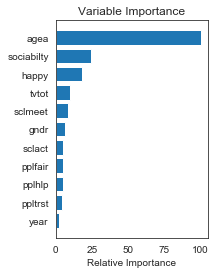

In [144]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()